In [1]:
import sys
sys.path.append("../../../")

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from model.losses import *
from model.bpho.multi import *
from model.bpho.resnet import *
from model.bpho.unet import *
from model.metrics import psnr, ssim
from data.load_fluo import *

In [3]:
torch.cuda.set_device(2)

# Model loading

### load data

In [4]:
bs = 8  # batch size
size = 1000  # image size
tile_sz=512 
lr_type = 't'
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/')
model_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/feat_loss')
if lr_type == 's':
    z_frames, t_frames = 1, 1
    n_frames = 1
    dataset = data_pth/'mitotracker_PSSR-SF'
    hr_tifs = dataset/f'hr'
    lr_tifs = dataset/f'lr'
elif lr_type == 't':
    z_frames, t_frames = 1, 5
    n_frames = 5
    multi_str = f'_{lr_type}_{n_frames}'
    tile_sz = 512
    dataset = data_pth/'mitotracker_PSSR-MF'
    hr_tifs = dataset/f'hr_t_{tile_sz:d}{multi_str}'
    lr_tifs = dataset/f'lr_t_{tile_sz:d}{multi_str}'

In [5]:
mode = 'L'
norm = True
noise = False
cutout = False # Maybe?

In [6]:
data = get_data(bs, size, lr_tifs, hr_tifs, n_frames=n_frames,  max_zoom=4., 
                    use_cutout=cutout, use_noise=noise, mode=mode, norm=norm)

normalizing x and y data


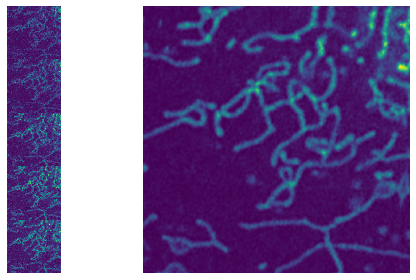

In [7]:
data.show_batch(rows=1)

### initiate learner

In [8]:
wnres_args = {
    'blur': True,
    'blur_final': True,
    'bottle': True,
    'self_attention': True,
    'last_cross': True
    
}
arch = 'wnresnet34'
wd = 1e-3
arch = eval(arch)
metrics = [psnr, ssim]

In [9]:
learn = wnres_unet_learner(data, arch, in_c=n_frames, wnres_args=wnres_args,
                         metrics=metrics,
                           model_dir=model_pth, callback_fns=[LossMetrics], wd=wd)

In [10]:
learn.model_dir

PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/feat_loss')

In [11]:
learn = learn.load(file='fluo_inpainting_100epoch')

# load testing data

In [13]:
test_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/LR/real-world_mitotracker')

In [14]:
MultiImageImageList.from_folder(test_pth)

OSError: Failed to interpret file PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/LR/real-world_mitotracker/realworld_lowres_lowpower_10_LR.tif') as a pickle

In [16]:
np.load(Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/LR/real-world_mitotracker/realworld_lowres_lowpower_10_LR.tif'),
       allow_pickle=True)

OSError: Failed to interpret file PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/LR/real-world_mitotracker/realworld_lowres_lowpower_10_LR.tif') as a pickle

In [14]:
learn.data.add_test(test_set, tfm_y=False)

ValueError: Cannot load file containing pickled data when allow_pickle=False

In [34]:
np.load(test_pth/'realworld_lowres_lowpower_10_LR.tif')

ValueError: Cannot load file containing pickled data when allow_pickle=False

## test

In [16]:
sys.path.append("../../../model")

In [17]:
critic_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models')
critic = load_learner(path=critic_pth/'baselines', file='mitotracker_PSSR-SF_512.pkl')

# Inference

In [75]:
critic.data.add_test(test_set, tfm_y=False)

In [76]:
critic.data.test_ds[0]

(Image (3, 128, 128), EmptyLabel )

In [67]:
file=test_pth/'realworld_lowres_lowpower_10_LR.tif'

In [68]:
file.exists()

True

In [69]:
img2=PIL.Image.open(file)

In [70]:
img2.size

(250, 250)

In [77]:
hr_pth=Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/HR/real-world_mitotracker')

In [78]:
hr_file=hr_pth/'realworld_highres_01_HR.tif'

In [79]:
hr_img=PIL.Image.open(hr_file)

In [80]:
hr_img.size

(1000, 1000)

In [58]:
img.data.shape

torch.Size([3, 128, 128])

In [34]:
for img, img_name in zip(critic.data.test_ds, critic.data.test_ds.items):
    pred = critic.predict(img[0])
    break

RuntimeError: Given groups=1, weight of size 32 1 3 3, expected input[1, 3, 512, 512] to have 1 channels, but got 3 channels instead

In [10]:
files = sorted(list(data_pth.glob('*.tif')))

In [12]:
files[0]

PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/mitotracker_PSSR-MF/hr_t_512_t_5/train/mitotracker/mitotracker_PSSR-MF_train_hr_0001.tif')

In [16]:
img=PIL.Image.open(files[0])

In [18]:
img.size

(512, 512)

In [7]:
# Store dataset in a databunch object 
data = get_data(data_pth, lr_dir, hr_dir, bs, 
                in_sz=size, out_sz=size, max_zoom=1.)

In [8]:
from model.metrics import psnr, ssim
superres_metrics = [F.mse_loss, psnr, ssim]

In [85]:
def model_inference(learner=learn, nb=nb_name, img_tag=f'{nb_name}.{expt_num}'):
    for img, img_name in zip(learner.data.test_ds, learner.data.test_ds.items):
        pred = learner.predict(img[0])
        pred_name = str(img_name).replace('FRC_8bit', nb+'/FRC').replace('000000', '_'+img_tag+'_')
        pred[0].save(pred_name)
        print(f"Performed inference on {img_name.stem}, file saved as {pred_name}")
    print("Model Inference Complete")

In [87]:
for pth in ['EM/testing/FRC_8bit/2_8bit', 'EM/testing/FRC_8bit/3_8bit']:
    test_pth = data_pth/pth
    print(test_pth)
    print(test_pth.exists())
    test_set = ImageList.from_folder(test_pth)
    learn.data.add_test(test_set, tfm_y=False)
    model_inference(learn)

/home/alaa/Dropbox/BPHO Staff/USF/EM/testing/FRC_8bit/2_8bit
True
Performed inference on 2_8bit00000007, file saved as /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/feat_loss_pssr_baseline/FRC/2_8bit/2_8bit_featureloss-resnet34-mse-baseline.3b_07.tif
Performed inference on 2_8bit00000000, file saved as /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/feat_loss_pssr_baseline/FRC/2_8bit/2_8bit_featureloss-resnet34-mse-baseline.3b_00.tif
Performed inference on 2_8bit00000006, file saved as /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/feat_loss_pssr_baseline/FRC/2_8bit/2_8bit_featureloss-resnet34-mse-baseline.3b_06.tif
Performed inference on 2_8bit00000002, file saved as /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/feat_loss_pssr_baseline/FRC/2_8bit/2_8bit_featureloss-resnet34-mse-baseline.3b_02.tif
Performed inference on 2_8bit00000015, file saved as /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/feat_loss_pssr_baseline/FRC/2_8bit/2_8bit_featureloss-resnet34-mse-baseline.3b_15.tif
Performed infe

## DEV

In [25]:
ex_img = learn.data.test_ds[0]
ex_img_name = learn.data.test_ds.items[0]

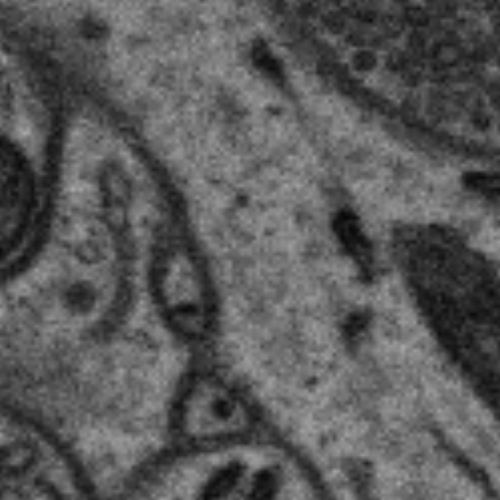

In [30]:
ex_img[0]

In [35]:
img = utils.load_img("test_inference.tif")

In [28]:
pred = learn.predict(ex_img[0])

In [31]:
pred[0].save("test_inference.tif")

In [42]:
ex_img_name.stem

'realword_SEM_test_lr_05'

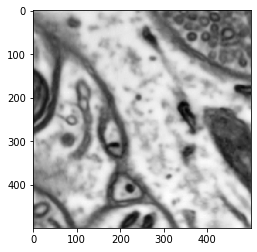

In [39]:
plt.imshow(np.squeeze(img), cmap=plt.cm.gray)